In [1]:
import numpy as np
import pandas as pd
import os
import random
from pathlib import Path as pt
import torch
import torchaudio
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio import transforms
import torchaudio.transforms as T
from torchvision.transforms import v2
# from Moduls.MosreDataset import MosreDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn.parallel import DataParallel

DIVICE = torch.device("cuda")

MAIN = pt(os.getcwd())
DATASET_PATCH = MAIN / 'morse_dataset'
AUDIO_FILES = DATASET_PATCH / 'morse_dataset'

# Поятоянные значения выявленные в процессе анализа
MORSEALP = "АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ 1234567890#"
MAX_TIME = 48
SAMPLE_RATE = 8000
N_MELS = 128
N_FFT = 400
HOP_LENGTH = 180
TOP_DB = 80
FREQ_MASK = 30
TIME_MASK = 40

# Гиперпараметы обучения
SEED = 42
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001 #2e-4
WEIGHT_DECAY = 0.0001
# int_to_alph = dict(enumerate(MORSEALP))
# alph_to_int = {char:enum for enum, char in int_to_alph.items()}

#===== Import data =====
train_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'train.csv'))
test_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'test.csv'))
sample_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'sample_submission.csv'))

class MorseDataset(Dataset):
    def __init__(self, df, audio_dir, char_map, audio_transform=None, is_test=False):
        self.df = df; 
        self.audio_dir = audio_dir; 
        self.char_map = char_map
        self.audio_transform = audio_transform.cpu() if audio_transform is not None else None
        self.is_test = is_test; 
        self.int_to_char = {v: k for k, v in char_map.items()}
    def __len__(self): 
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_id = row['id']
        audio_path = os.path.join(self.audio_dir, file_id)
        # print(audio_path)
        waveform, sr = torchaudio.load(audio_path)
        if sr != SAMPLE_RATE:
            waveform = T.Resample(sr, SAMPLE_RATE)(waveform)

        current_transform = self.audio_transform
        spectrogram = current_transform(waveform).squeeze(0).unsqueeze(0) # (1, M, T)
        if not self.is_test:
            text = row['message']; 
            target = torch.tensor([self.char_map[char] for char in text], dtype=torch.long); 
            target_len = torch.tensor(len(target), dtype=torch.long)
            # Возвращаем spec_length, хотя он будет одинаковым для трейна
            return spectrogram, target, spectrogram.shape[-1], target_len
        else: 
            return spectrogram, spectrogram.shape[-1], file_id


    
FIRST_FE_COUNT = 16
SECOND_FE_COUNT = 32
THIRD_FE_COUNT = 32
QAD_FE_COUNT = 32
PADDING = 'same'
MAXPOOL_KERNEL = 2
KERTNEL_SIZE = 3
NERON_COUNT = 128
GRU_HIDEN = 256
# Start with 4 transforms
from collections import Counter, defaultdict
all_chars = Counter("".join(train_data['message']))

BLANK_CHAR = "_"
vocab_list = sorted(all_chars.keys()) + [BLANK_CHAR]
vocab_size = len(vocab_list)
char_to_int = {char: i for i, char in enumerate(vocab_list)}
int_to_char = {i: char for i, char in enumerate(vocab_list)}
BLANK_IDX = char_to_int[BLANK_CHAR]
class MorseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net_conv = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=FIRST_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(FIRST_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((1, 2), (1, 2)), # [batch, FIRST_FE_COUNT = 16, 64, 960]

            nn.Conv2d(in_channels=FIRST_FE_COUNT, 
                      out_channels=SECOND_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(SECOND_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((2, 1), (2, 1)), # [batch, SECOND_FE_COUNT = 32, 32, 480]

            nn.Conv2d(in_channels=SECOND_FE_COUNT, 
                      out_channels=THIRD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(THIRD_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((2, 2), (2, 2)), # [batch, THIRD_FE_COUNT = 32, 16, 240]

            nn.Conv2d(in_channels=THIRD_FE_COUNT, 
                      out_channels=QAD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(QAD_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((2, 1), (2, 1)) # [batch=32, QAD_FE_COUNT = 32, 8, 80](что юы сохраниить большще признаков по горизонтали)
        )
        with torch.no_grad(): 
            dummy_input = torch.randn(1, 1, N_MELS, 480); 
            cnn_out = self.net_conv(dummy_input); 
            self.cnn_output_features = cnn_out.shape[1] * cnn_out.shape[2]
        print(f"CNN размерность выхода: {cnn_out.shape}"); 
        print(f"CNN число фичей: {self.cnn_output_features}")

        # Добавлен лоейный слой и функция активации. Для чего? расписать потом 
        self.layer1 = nn.Linear(self.cnn_output_features, N_MELS*2); 
        self.gelu = nn.LeakyReLU()
        print(f"Проекция из {self.cnn_output_features} в {GRU_HIDEN*2}")
        self.rnn = nn.GRU(input_size=N_MELS*2,hidden_size=GRU_HIDEN, num_layers=3 ,bidirectional=True)
        
        self.embed_dim = GRU_HIDEN * 2

        self.layer_norm = nn.LayerNorm(self.embed_dim)      
        self.layer2 = nn.Linear(self.embed_dim, len(MORSEALP))       
        # self.layer3 = nn.Linear(GRU_HIDEN, GRU_HIDEN // 2)       
        # self.layer4 = nn.Linear(GRU_HIDEN // 2, 45)             

    def forward(self, x):
        x = self.net_conv(x)

        batch, channels, reduced_mels, reduced_time = x.shape
        x = x.permute(0, 3, 1, 2)  # [batch, time, channels, mels]
        # В частности, каждый вектор признаков в последовательности признаков генерируется 
        # слева направо на картах признаков. Это означает, что i-й вектор признаков представляет 
        # собой объединение столбцов всех карт. 
        # Таким образом, форма тензора может быть изменена, например, на (размер_пакета, 80, 256)
        x = x.reshape(batch, reduced_time, -1)  # to GRU [batch=32, seq_len=80, features=256]
        x = self.layer1(x)
        x = self.gelu(x)
        self.rnn.flatten_parameters()
        x = self.rnn(x)
        x, _ = x # берем информацию со всез состояний
        x = self.layer_norm(x)
        x = self.layer2(x)
        x = nn.functional.log_softmax(x.permute(1, 0, 2), dim=2)
        # x = self.layer3(x)
        # x = self.layer4(x)
        # x = x.log_softmax(dim=2) #log_softmax дает лучше распределение вероятностей чем softmax

        return x
    

train_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    # transforms.AmplitudeToDB(top_db=TOP_DB),
    transforms.FrequencyMasking(freq_mask_param=FREQ_MASK),
    transforms.TimeMasking(time_mask_param=TIME_MASK),
    # v2.RandomCrop((N_MELS, 1920)) # Обрезает последний кадр спектрограммы, в идеале надобы считать а не прописывать число
    ) # заметка - Данные трансформации не создают довых обучаемых параметров. Но есть и те что создают. В будущем это стоит учитывать

valid_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    transforms.AmplitudeToDB(top_db=TOP_DB),
    v2.CenterCrop((N_MELS, 1920)) 
    )

train_dataframe, val_dataframe = train_test_split(train_data, test_size=0.15, random_state=SEED)

train_ds = MorseDataset(df=train_dataframe,
                        audio_dir=AUDIO_FILES,
                        char_map=char_to_int,
                        audio_transform=train_audio_transforms,is_test=True)

val_ds = MorseDataset(df=val_dataframe,
                        audio_dir=AUDIO_FILES,
                        char_map=char_to_int,
                        audio_transform=train_audio_transforms)

def collate_fn(batch):
    valid_batch = [item for item in batch if item[0] is not None]
    if not valid_batch: return None, None, None, None, None
    is_test_batch = len(valid_batch[0]) == 3
    if not is_test_batch: spectrograms, targets, spec_lengths, target_lengths = zip(*valid_batch); ids = None
    else: spectrograms, spec_lengths, ids = zip(*valid_batch); targets, target_lengths = None, None
    spectrograms_permuted = [s.squeeze(0).permute(1, 0) for s in spectrograms]
    spectrograms_padded = nn.utils.rnn.pad_sequence(spectrograms_permuted, batch_first=True, padding_value=0.0)
    spectrograms_padded = spectrograms_padded.permute(0, 2, 1).unsqueeze(1)
    spec_lengths_tensor = torch.tensor(spec_lengths, dtype=torch.long)
    if not is_test_batch:
        targets_padded = nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=BLANK_IDX)
        target_lengths_tensor = torch.tensor(target_lengths, dtype=torch.long)
        return spectrograms_padded, spec_lengths_tensor, targets_padded, target_lengths_tensor, None
    else: return spectrograms_padded, spec_lengths_tensor, None, None, list(ids)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

spec, spec_lengths, targets_padded, target_lengths_tensor, _ = next(iter(train_dl))

# test_val, val_target, _ = next(iter(val_dl))
# test_val, val_target = test_val.to(DIVICE), val_target.to(DIVICE)
# # test.shape 

# #===== начало обучения =====
model = MorseNet().to(DIVICE)
model = DataParallel(model)
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=6, verbose=True)
loss_func = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True).to(DIVICE)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nMorseNet - инициалицация модели. Число обучаемых параметров: {total_params:,}")

CNN размерность выхода: torch.Size([1, 32, 16, 120])
CNN число фичей: 512
Проекция из 512 в 512

MorseNet - инициалицация модели. Число обучаемых параметров: 3,333,901


In [2]:
spec.shape

torch.Size([32, 1, 128, 356])

In [3]:
a = model(spec)
a.shape

torch.Size([89, 32, 45])

In [46]:
model(spec).shape

NameError: name 'model' is not defined

# Класс модели

Переменные для обучения.

In [ ]:
# a = model(test)
# a

# Обучение модели

In [2]:
lst_loss_train = []
lst_loss_val = []
p = []
p_Val = []
for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0
    pr = []

    train_tqdm = tqdm(train_dl, desc=f"Эпоха {epoch+1}/{EPOCHS} [Обучение]", leave=False)
    for mel_spec, labels, label_lens, _ in train_tqdm:
        mel_spec, labels, label_lens = mel_spec.to(DIVICE), labels.to(DIVICE), label_lens.to(DIVICE)

        #===== считатем длинну mel_spec для передачи в CTC loss =====
        
        optimizer.zero_grad()
        predict = model(mel_spec) # (N=batch,T,C)
        pr.append(predict)
        N = predict.shape[1]
        T = predict.shape[0]
        predict_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)

        # print(N, T, predict.shape, labels.shape, predict_lengths.shape, label_lens.shape)
        # break
        loss = loss_func(predict, labels, predict_lengths, label_lens)

        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        train_loss = epoch_train_loss / len(train_data)

    # ======== Валидация ========
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for val_mel_spec, val_labels, val_label_lensin, _ in tqdm(
                                                        val_dl, 
                                                        desc=f"Эпоха {epoch+1}/{EPOCHS} [Валидация]", 
                                                        leave=False):
            val_mel_spec, val_labels, val_label_lensin = val_mel_spec.to(DIVICE), val_labels.to(DIVICE), val_label_lensin.to(DIVICE)
            val_predict = model(val_mel_spec)

            p_Val.append(val_predict)
            val_N = val_predict.shape[1]
            val_T = val_predict.shape[0]
            predict_val_lengths = torch.full(size=(val_N,), fill_value=val_T, dtype=torch.long)
            val_loss += loss_func(val_predict, val_labels, predict_val_lengths, val_label_lensin).item()



    lst_loss_train.append(train_loss)
    lst_loss_val.append(val_loss)

            
    print(f"\n===== Эпоха {epoch+1}/{EPOCHS} =====")
    # print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    grad_norms = [param.grad.norm().item() for param in model.parameters() if param.grad is not None]
    if grad_norms:
        print(f"Mean grad norm: {np.mean(grad_norms):.6f}")
        print(f"Max grad norm: {np.max(grad_norms):.6f}")
        print(f"Min grad norm: {np.min(grad_norms):.6f}")
    else:
        print("No gradients computed yet.")

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print("-" * 50)


===== Эпоха 1/20 =====
Mean grad norm: 0.100248
Max grad norm: 2.922087
Min grad norm: 0.000000
Train Loss: 0.1075
Val Loss: 531.0693
--------------------------------------------------


KeyboardInterrupt: 

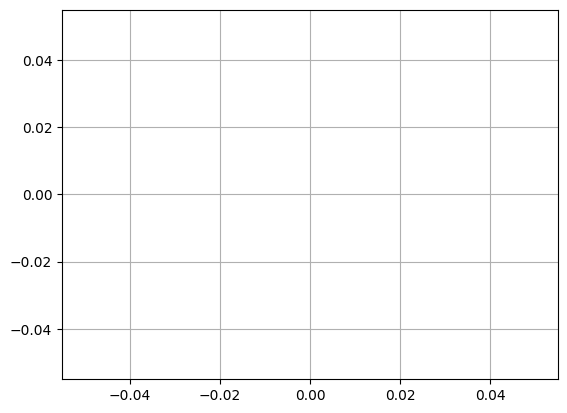

In [89]:
plt.plot(lst_loss_train)
plt.plot(lst_loss_val)
plt.grid()
plt.show()